In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../Data/www/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
%matplotlib inline

import json
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from scipy.special import erf
from collections import Counter

# Synopsis

In this unit we will discuss how to randomly generate possible data sets from a set of sample data (known as bootstrapping). To do that we will cover:

* Why/when you would need to bootstrap data
* How to bootstrap data
* How to statistically evaluate bootstrapped data

# Bootstrap methods

When doing science, ideally, one would have many replicates of an experiment.  The replicates would enable us to calculate both an expected outcome and the variability in outcomes.  Those quantities would then enable us, under certain assumptions, to estimate the chance that some observed difference from a null model could be explained by chance or not.

But what can we do when we only have one replicate?  This is frequently the case with observational studies, but it can occur in other contexts too.

However, there are other areas where Bootstrapping Monte Carlo chains is a useful computational approach.

One area, that you might not have though of, is estimating a value.

A classic example is trying to calculate what is the value of $pi$. $pi$ isn't an actual numerical number, it's the ratio of a circle's circumference to its diameter.

While your calculator now knows what that approximation is a number---how would you calculate it?

.

.

.

.

Well one way is to numerically approximate it using a bootstrap.

The procedure is actually pretty simple. All we would do is randomly select points in the unit-square and then check to see if it's inside the circle or not.

Our overall estimate of the value of $pi$ would then just be the number of points successfully within the circle divided by the number of points we randomly picked.

In [3]:
# Calculate pi by calculating area of quarter circle

def estimate_pi(n_attempts = 10000):
    """ Estimate pi from area of quarter circle """ 
    count_successes = 0
    for i in range(n_attempts):
        x_rand = np.random.random()
        y_rand = np.random.random()
        dist = math.sqrt( x_rand **2 + y_rand**2 )
        if dist <= 1.:
            count_successes += 1
    return float(count_successes) / n_attempts


print( math.pi / 4. )
print( estimate_pi(10) )

0.7853981633974483
0.5


What you'll see, is that our estimate of $pi$ gets increasingly better the more points that we choose.

In [4]:
print( math.pi / 4. )
print( estimate_pi(100000) )

0.7853981633974483
0.78521


And with enough random points our answer will converge to the exact answer that the computer already returns.

This may seem like a pretty simple example (because you were taught what the value of $pi$ is), but this is actually a very real problem --- a lot of the time we don't know what the value of some distribution is and we **don't** know an equation to calculate it so we need to numerically approximate it using a Monte Carlo Bootstrap.

We can also use this method to easily estimate probabilities --- like what is the probability that the sum of the dots on two die will equal a certain value?

In [5]:
import numpy as np

def prob_of_outcome_tossing_n_dice(sum_dots, n, n_attempts = 1000):
    """ Probability of the sum of the dots in n dice being sum_dots"""
    count_successes = 0
    for a in range(n_attempts):
        # Toss dice
        sum_temp = 0
        for i in range(n):
            sum_temp += np.random.randint(6) + 1
        if sum_temp == sum_dots:
            count_successes += 1
    
    return float(count_successes) / n_attempts

print( prob_of_outcome_tossing_n_dice(3, 2, 10) )
print( prob_of_outcome_tossing_n_dice(3, 2, 100) )
print( prob_of_outcome_tossing_n_dice(3, 2) )
print( prob_of_outcome_tossing_n_dice(3, 2, 1000000) )

0.0
0.07
0.052
0.056057


# Bootstrapping data

Back when we first analyzed text, I asked the question of whether the play 'Othello' should have been named 'Iago'. That question came from the fact, that at a rudimentary analysis, Iago seems to be the main speaker from a data analysis perspective. 

However, in the exercises we switched to a more complex metric, the entropy, evaluate who was the more articulate speaker (with our idea being that the more articulate speaker may be the main character). When we calculated the entropy Iago had a slightly higher measure than Othello's. The problem is we didn't know how to answer if the **difference was significant**.

This is a common situation - you use all of your available data points to calculate a single metric that encodes some measure or performance of the data. However, this leaves you with only one number for each category (which is essentially just **one observation**) --- there's no way that you can run a t-test with just one observation (at least I hope you would never try)!

What do you do?

## The bootstrap -- or creating ensembles of data

The answer is to bootstrap your data. What this means seems complicated but it actually is very simple, the procedure is as follows:

1. Randomly select individual data points from our source data to create a new synthetic dataset
2. Calculate our metric of interest on the synthetic dataset
3. Repeat steps 1-2 $10^3$ - $10^6$ times (depending on data/metric)
4. Evaluate the distribution of synthetic results to the real value from the data

Put simply, we create lots of *possible* datasets from our observed data and see how our value compares to the *possible* data (or how one set of *possible* data compares to another set of *possible* data).

There are only two ways to sample data to generate synthetic datasets -- **with or without** replacement. 

* **with replacement** when we select a data point to put in our synthetic dataset, we leave it in the original dataset so it could be drawn again
* **without replacement** when we select a data point to put in our synthetic dataset, we remove it from the original dataset so it cannot be drawn again

## What's the difference between these two methods?

Well, it's somewhat hard to give a definition that is both concrete/understandable and general --- but as a guideline:

If you are interested in calculating the difference between two metrics or an observed value against a probable process, you are most likely interested in sampling **with replacement**. To do this you typically keep the synthetic dataset size **fixed** and **equal to the original number of observations**. If you sampled without replacement then you would generate synthetic datasets that are identical to each other and the original dataset.

If you are interested in calculating the relationship between datapoints in time (i.e. one value following another in time), you are more likely intersted in sampling **without replacement**. You're interested not in observing different values, which 'with replacement' would give, but instead if there is a difference in how one data point follows another in time. 

# The entropy of Othello and Iago

To make this concrete, let's recap the entropy of Othello and Iago's dialogue. 

First we have to read in the dialogue and calculate the entropy.

In [6]:
def extract_othello_play():
    '''
    Extracts the othello play from the Shakespeare.txt file
    '''
    complete_works = open('../Data/Day5-Text-Analysis/Shakespeare.txt').read()
    #Cut off the beginning plays
    othello_full = complete_works.split('OTHELLO, MOOR OF VENICE\n\nby William Shakespeare\n\n\n\n')[1]
    #Cut off the plays after
    othello_text = othello_full.split('\n\n\nTHE END')[0]
    #Clean out the electronic message
    emessage = '''<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM\nSHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS\nPROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE\nWITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE\nDISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS\nPERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED\nCOMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY\nSERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>'''
    emessage_split = othello_text.split(emessage)
    #Preamble is the first part
    othello_preamble = emessage_split[0]
    #Text is the other part
    othello_clean_text = ''.join(emessage_split[1:])
    othello_lines = othello_clean_text.split('\n')
    return othello_lines

In [7]:
def strip_punctuation(word):
    punc = ',.:;"\'?![]{}-'
    return word.lstrip(punc).strip(punc).lower()

def find_character_dialogue(character_name, text):
    '''
    Finds all dialogue lines for a given character name
    input:
        character_name: name of character, all caps including period. 
        text: text to find character name in
    output:
        dialogue: list of words character uses
    '''
    dialogue = []

    #I create a variable to track if othello was the last character speaking
    preceding_character = False
    for line in text:
        #First check is if we are in a correct character block of dialogue or not
        if preceding_character == True:
            #Check to make sure that another character isn't speaking
            #Continued text starts with four spaces
            if '    ' == line[:4]:
                dialogue += [w for w in line.split(' ') if w != '' and w != ' ']
            else:
                #Character isn't speaking, flip the preceding_othello flag
                preceding_character = False
        else:
            #lets check to see if character is speaking
            if character_name in line:
                #append the line to othellos dialogue
                dialogue += [w for w in line.split(character_name)[1].split(' ') if w != '' and w != ' ']
                #Switch our preceding check to true
                preceding_character = True
            else:
                #I am explicitly accounting for the character not speaking, but not using this for anything
                pass
    return dialogue

othellos_dialogue = [strip_punctuation(w) for w in find_character_dialogue('OTHELLO.', extract_othello_play())]
iagos_dialogue = [strip_punctuation(w) for w in find_character_dialogue('IAGO.', extract_othello_play())]

In [8]:
def calc_entropy(words):
    '''
    input:
        words: list of all words uttered
    output:
        entropy: float
    '''
    total_words = len(words)
    counted_words = Counter(words)  
    #Start the calculation
    entropy = 0
    for word, value in counted_words.items():
        entropy += value/total_words * np.log(value/total_words)
    return -1 * entropy

print('Othello ', calc_entropy(othellos_dialogue))
print('Iago ', calc_entropy(iagos_dialogue))

Othello  6.126593244621015
Iago  6.139003713381113


## So now the question is....are these different?

Well, to be facetious we can run a t-test on the two values.

In [10]:
import scipy.stats as stats

othello_entropy = calc_entropy(othellos_dialogue)
iago_entropy = calc_entropy(iagos_dialogue)

stats.ttest_ind([othello_entropy], [iago_entropy] )

Ttest_indResult(statistic=nan, pvalue=nan)

Yup, doesn't work because we only have one value! So we need to bootstrap, so how can we set this problem up?

Well, let's break this down further.

We have two individual metrics that summarize a dataset and we want to know if they significantly differ.

To bootstrap, we really need to calculate if one observed value is different than a synthetic distribution of data. Anything more and it becomes hard to really interpret the comparisons.

So what's the answer to make this doable? 

Well we can actually bootstrap the **difference** in entropy between Othello's and Iago's dialogue! That's a single metric that we can easily compare.

So what do we care about? 

Well the dialogue size of both Iago and Othello should be fixed to account for that difference. This suggests that we should sample each individual's dialogue with replacement from their original dialogue. Then we record the difference between the two synthetic dialogues.

If the the real difference is significantly larger than the synthetically generated dialogues' differences then we would conclude that the entropy of one character is significantly different than random language usage.

So how do we do this? Well first we should write a function to generate synthetic dialogue for a single character

In [17]:
import numpy as np
import random 

In [25]:
x=[1,2,3,4,5]
np.random.choice(x,len(x))

array([3, 4, 3, 5, 3])

In [22]:
#Your code here
othellos_dialogue_synthetic=np.random.choice(othellos_dialogue,len(othellos_dialogue))
iagos_dialogue_synthetic=np.random.choice(iagos_dialogue,len(iagos_dialogue))

In [23]:
print('Othello ', calc_entropy(othellos_dialogue_synthetic))
print('Iago ', calc_entropy(iagos_dialogue_synthetic))

Othello  5.936396277817935
Iago  5.993587100912084


In [26]:
def synthetic_dialogue_generator(dialogue):
    import random
    new_dialogue = []
    for i in range(len(dialogue)):
        new_dialogue.append( random.choice(dialogue) )
    return new_dialogue

synthetic_dialogue = synthetic_dialogue_generator(othellos_dialogue)
print( len(synthetic_dialogue) )
print(synthetic_dialogue[:10])

6284
['at', 'of', 'will', 'not', 'heaven', 'cassio', 'so', 'voices', 'to', 'and']


Now we should write a function that generates synthetic dialogues for each character and calculates the difference in entropy. This function should generate 1000 synthetic dialogues

In [32]:
#Your code here
othellos_entropy=[]
iagos_entropy=[]
for i in range(0,1000):
    othellos_dialogue_synthetic=np.random.choice(othellos_dialogue,len(othellos_dialogue))
    iagos_dialogue_synthetic=np.random.choice(iagos_dialogue,len(iagos_dialogue))
    othellos_entropy.append(calc_entropy(othellos_dialogue_synthetic))
    iagos_entropy.append(calc_entropy(iagos_dialogue_synthetic))

In [33]:
import seaborn as sns

In [38]:
def half_frame(sub, xaxis_label, yaxis_label, font_size = 15, padding = -0.02):
    """Formats frame, axes, and ticks for matplotlib made graphic with half frame."""

    # Format graph frame and tick marks
    sub.yaxis.set_ticks_position('left')
    sub.xaxis.set_ticks_position('bottom')
    sub.tick_params(axis = 'both', which = 'major', length = 7, width = 2, direction = 'out', pad = 10,
                    labelsize = font_size)
    sub.tick_params(axis = 'both', which = 'minor', length = 5, width = 2, direction = 'out', labelsize = 10)
    for axis in ['bottom','left']:
        sub.spines[axis].set_linewidth(2)
        sub.spines[axis].set_position(("axes", padding))
    for axis in ['top','right']:
        sub.spines[axis].set_visible(False)

    # Format axes
    sub.set_xlabel(xaxis_label, fontsize = 1.6 * font_size)
    sub.set_ylabel(yaxis_label, fontsize = 1.6 * font_size)
    
    return

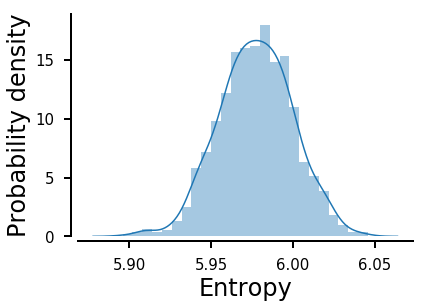

In [44]:
fig = plt.figure( figsize = (6,9 ) )
ax = fig.add_subplot(2,1,1)
my_font_size = 15
half_frame(ax, "Entropy", "Probability density", font_size = my_font_size)
sns.distplot(othellos_entropy,ax=ax)

In [35]:
def generate_synthetic_entropies_difference(dialogue1, dialogue2, n=1000):
    synthetic_entropies = []
    for i in range(n):
        ent1 = calc_entropy( synthetic_dialogue_generator(dialogue1) )
        ent2 = calc_entropy( synthetic_dialogue_generator(dialogue2) )
        synthetic_entropies.append(ent1 - ent2)
    return synthetic_entropies

 = generate_synthetic_entropies_difference(othellos_dialogue, iagos_dialogue)

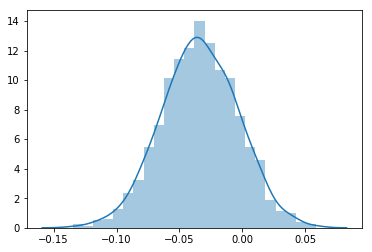

In [36]:
fig = plt.figure( figsize = (6,9 ) )
ax = fig.add_subplot(2,1,1)
my_font_size = 15
half_frame(ax, "D", "Probability density", font_size = my_font_size)
sns.distplot(synth_diffs,ax=ax)

Great! So now we can see that the difference in entropy of the dialogue between the two characters is not distinct.

If we had approached this problem in a different manner, say looking at a single individual's dialogue and comparing it to the synthetic distribution it would have been much more complicated. 

Framing the problem is one of the most important parts of properly bootstrapping data to understand significance! 